<a href="https://colab.research.google.com/github/pietrodileo/Python_for_MD_thesis/blob/main/TrainCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 🚀 Install, Import, Login

Setup for W&B Tool

In [651]:
# Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install wandb
# import wandb
# from wandb.keras import WandbCallback
## 075552994aad288a1162d4ab06f96040112fd54c
# wandb.login()

# wandb.init()
# config = wandb.config

Import Libraries

In [652]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
import sys
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model
import itertools
import time
import shutil
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [653]:
!pip install aspose-words
import aspose.words as aw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [654]:
# To save static image with plotly
%%capture
!pip install kaleido
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

Calculate execution time

In [655]:
start_time = time.time()

## 2. Preparing the data
We can now load the spectrograms into memory. We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation. The validation set is what will ultimately be our benchmark when becomes to performance and accuracy of our classifier. The batch size is set fairly low for now (32) for all images to fit in memory. The seed is for reproducibility.

In [656]:
def createTrain_and_Test_Dataset(directory,BATCH_SIZE,VAL_SPLIT,IMAGE_HEIGHT, IMAGE_WIDTH, MODE):
  # Make a dataset containing the training spectrograms
  train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            directory,
                                            labels='inferred',
                                            batch_size=BATCH_SIZE,
                                            validation_split=VAL_SPLIT,
                                            subset='training',
                                            shuffle=True,
                                            color_mode= MODE,
                                            image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                            seed=0)

  # Make a dataset containing the validation spectrogram
  valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            directory,
                                            labels='inferred',
                                            batch_size=BATCH_SIZE,
                                            validation_split=VAL_SPLIT,
                                            subset='validation',
                                            shuffle=True,
                                            color_mode= MODE,
                                            image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                            seed=0)
  return train_dataset, valid_dataset

Before we can build our model and start training, we need to apply one simple augmentation the dataset and that is rescaling. We convert input from int to float32 and rescale it from the (0, 255) range to the (0,1) range.

In [657]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])

    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    # if augment == True, do ImageAugmentation
    if augment: 
      ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

# 2. 🧠 Define the Model and Train

In [658]:
def make_model(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS, N_CLASSES):
  # Create CNN model with 3 Convolution Layer Architecture
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
  # Conv2D(NumFilter, FilterSize, option...)
  model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')) #kernel_initializer='he_uniform'
  #model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  #model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
  #model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  #model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
  #model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  #model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256, activation='relu')) 
  #model.add(tf.keras.layers.BatchNormalization())
  #model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))
  return model

In [659]:
# def plotResults(history,SaveFile,outputPath):
#   # Plot the loss curves for training and validation.
#   history_dict = history.history
#   loss_values = history_dict['loss']
#   val_loss_values = history_dict['val_loss']
#   epochs = range(1, len(loss_values)+1)

#   plt.figure(figsize=(10,15))
#   plt.subplot(211)
#   plt.plot(epochs, loss_values, 'g', label='Training loss')
#   plt.plot(epochs, loss_values, 'go')
#   plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
#   plt.plot(epochs, val_loss_values, 'bo')
#   plt.title('Training and validation loss')
#   plt.xlabel('Epochs')
#   plt.ylabel('Loss')
#   plt.legend()
#   plt.show()

#   # Plot the accuracy curves for training and validation.
#   acc_values = history_dict['accuracy']
#   val_acc_values = history_dict['val_accuracy']
#   epochs = range(1, len(acc_values)+1)

#   plt.figure(figsize=(10,15))
#   plt.subplot(221)
#   plt.plot(epochs, acc_values, 'g', label='Training accuracy')
#   plt.plot(epochs, acc_values, 'go')
#   plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
#   plt.plot(epochs, val_acc_values, 'bo')
#   plt.title('Training and validation accuracy')
#   plt.xlabel('Epochs')
#   plt.ylabel('Accuracy')
#   plt.legend()
#   plt.show()

#   if SaveFile == True:
#     AccLossPngOutput = os.path.join(outputPath,'results.png')
#     plt.savefig(AccLossPngOutput, bbox_inches='tight')
#     plt.close()
#     print('Image Saved')

In [660]:
def plotResults(history,SaveFile,outputPath):
  # Plot the loss curves for training and validation.
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  epochs = range(1, len(loss_values)+1)
  
  d = {'Train Loss': loss_values, 'Test Loss': val_loss_values, 'Epochs':epochs}
  df = pd.DataFrame(d)
  
  fig = go.Figure()
  fig = make_subplots(rows=2, cols=1,
                      subplot_titles=("Training and Validation Loss", "Training and Validation Accuracy"))

  fig.append_trace(go.Scatter(
      x=df['Epochs'],
      y=df['Train Loss'],
      name="Training Loss",       # this sets its legend entry
      mode='lines+markers'
  ),1,1),

  fig.append_trace(go.Scatter(
      x=df['Epochs'],
      y=df['Test Loss'],
      name="Validation Loss",
      mode='lines+markers'
  ),1,1),

  # Plot the accuracy curves for training and validation.
  acc_values = history_dict['accuracy']
  val_acc_values = history_dict['val_accuracy']
  epochs = range(1, len(acc_values)+1)

  d = {'Train Accuracy': acc_values, 'Test Accuracy': val_acc_values, 'Epochs':epochs}
  df = pd.DataFrame(d)

  fig.append_trace(go.Scatter(
      x=df['Epochs'],
      y=df['Train Accuracy'],
      name="Training Accuracy",       # this sets its legend entry
      mode='lines+markers'
  ),2,1),

  fig.append_trace(go.Scatter(
      x=df['Epochs'],
      y=df['Test Accuracy'],
      name="Validation Accuracy",
      mode='lines+markers'
  ),2,1),

  # edit axis labels
  fig['layout']['xaxis']['title']='Epochs'
  fig['layout']['xaxis2']['title']='Epochs'
  fig['layout']['yaxis']['title']='Loss'
  fig['layout']['yaxis2']['title']='Accuracy'

  # Tick Distance
  fig['layout']['xaxis']['dtick']= 5
  fig['layout']['xaxis2']['dtick']= 5
  # First value on x axis
  fig['layout']['xaxis']['tick0']= 0
  fig['layout']['xaxis2']['tick0']= 0
  # Tick Mode
  fig['layout']['xaxis']['tickmode']= 'linear'
  fig['layout']['xaxis2']['tickmode']= 'linear'

  fig.update_layout(
      height=800, 
      width=1200,
      title="Loss and Accuracy",
      legend_title="Dataset",
      font=dict(size=14)
  )

  return fig, loss_values, val_loss_values, acc_values, val_acc_values

# 3. 💯 Compute Code

Define Input and Output

In [661]:
TASK = '30epoche_NO_Batch_NO_Dropout_specProva'
directory = '/content/drive/MyDrive/DatasetTesi/outputSpectrogram/Spectrogram/prova'
outputPath = '/content/drive/MyDrive/DatasetTesi/outputSpectrogram/Spectrogram/Risultati'
outputPath = os.path.join(outputPath,TASK)

if not os.path.exists(outputPath):
   # Create a new directory because it does not exist
   os.makedirs(outputPath)
   print("The output folder has been created!")

Define Parameters for Training

In [662]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
EPOCHS = 50
VAL_SPLIT = 0.2
MODE = 'rgb'
SaveFile = True

[train_dataset, valid_dataset] = createTrain_and_Test_Dataset(directory,BATCH_SIZE,VAL_SPLIT,IMAGE_HEIGHT, IMAGE_WIDTH, MODE)

classNames = train_dataset.class_names
N_CLASSES = len(classNames)

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

Found 227 files belonging to 2 classes.
Using 182 files for training.
Found 227 files belonging to 2 classes.
Using 45 files for validation.


Make Model and Plot Results

In [663]:
# wandb.config = {
#   "learning_rate": 0.001,
#   "epochs": EPOCHS,
#   "batch_size": BATCH_SIZE,
#   "architecture": "CNN"
# }

model = make_model(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS, N_CLASSES)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

# wandb.init()

# Train model and capture the history
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=valid_dataset)

Epoch 1/50
6/6 [==============================] - 28s 3s/step - loss: 4.7419 - accuracy: 0.4396 - val_loss: 0.6834 - val_accuracy: 0.5556
Epoch 2/50
6/6 [==============================] - 18s 2s/step - loss: 0.6964 - accuracy: 0.4725 - val_loss: 1.6346 - val_accuracy: 0.5556
Epoch 3/50
6/6 [==============================] - 20s 3s/step - loss: 0.9896 - accuracy: 0.5769 - val_loss: 0.6467 - val_accuracy: 0.7111
Epoch 4/50
6/6 [==============================] - 18s 2s/step - loss: 0.6660 - accuracy: 0.6538 - val_loss: 0.6299 - val_accuracy: 0.6000
Epoch 5/50
6/6 [==============================] - 18s 2s/step - loss: 0.6278 - accuracy: 0.5769 - val_loss: 0.6363 - val_accuracy: 0.5556
Epoch 6/50
6/6 [==============================] - 19s 2s/step - loss: 0.5314 - accuracy: 0.7802 - val_loss: 0.4840 - val_accuracy: 0.6889
Epoch 7/50
6/6 [==============================] - 18s 2s/step - loss: 0.7306 - accuracy: 0.7198 - val_loss: 0.4795 - val_accuracy: 0.8000
Epoch 8/50
6/6 [==================

In [664]:
fig, loss_values, val_loss_values, acc_values, val_acc_values = plotResults(history,SaveFile,outputPath)
fig.show()

In [665]:
# Save pic in HTML
if SaveFile == True:
  AccLossPngOutput = os.path.join(outputPath,'results.html')
  fig.write_html(AccLossPngOutput)
  # Convert to PNG
  AccLossPngOutputPNG = os.path.join(outputPath,'results.png')
  
  # Load an existing Word document
  #doc = aw.Document(AccLossPngOutput)
  # Specify image save options
  # Set save format as PNG
  #imageOptions = aw.saving.ImageSaveOptions(aw.SaveFormat.PNG)
  # Save the pages as PNG
  #doc.save(AccLossPngOutputPNG, imageOptions)
  print('Image Saved')

Image Saved


Export Results to Google Drive

In [666]:
# ⭐: log metrics using wandb.log
# wandb.log({'epochs': EPOCHS,
#            'loss': loss_values,
#            'acc': acc_values, 
#            'val_loss': val_loss_values,
#            'val_acc':val_acc_values})

In [667]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.436006, final accuracy: 0.911111


In [668]:
runtime = time.time() - start_time

print('Runtime:')
print("--- %s seconds ---" % (runtime))
print("--- %s minutes ---" % ((runtime)/60))

Runtime:
--- 1056.1349654197693 seconds ---
--- 17.602249423662823 minutes ---


In [669]:
# dictionary of lists  
InfoDict = {'IMAGE_HEIGHT':[IMAGE_HEIGHT], 'IMAGE_WIDTH':[IMAGE_WIDTH],
              'BATCH_SIZE': [BATCH_SIZE], 'N_CHANNELS': [N_CHANNELS], 'N_CLASSES': [N_CLASSES],
              'EPOCHS':[EPOCHS], 'VAL_SPLIT': [VAL_SPLIT], 'MODE': MODE,
              'FINAL VALIDATION LOSS': [final_loss], 'FINAL VALIDATION ACC': [final_acc],
              'RUNTIME (s)': [runtime], 'RUNTIME (min)': [runtime/60]
              }
InfoDict
dfInfo = pd.DataFrame(InfoDict)
dfInfo.index = ['CNN']
# saving the dataframe 
outputName = 'Model_Info_and_Performance.xlsx'
OutputFileName = os.path.join(outputPath,outputName)
if SaveFile == True:
  # writing to Excel
  dfInfo.to_excel(OutputFileName)

In [670]:
# dictionary of lists  
OutputDict = {'Train_ACC':acc_values, 'Train_LOSS':loss_values, 
              'Test_ACC': val_acc_values, 'Test_LOSS': val_loss_values}
dfResult = pd.DataFrame(OutputDict) 
# saving the dataframe 
outputName = 'Risultati'
OutputFileName = outputPath+'/'+outputName+'.xlsx'
dfResult.to_excel(OutputFileName) 

In [671]:
Summary = os.path.join(outputPath,'modelsummary.txt')
modelInfo = model.summary()

stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

with open(Summary, 'w') as f:
  # Pass the file handle in as a lambda function to make it callable
  f.write(short_model_summary)

Model: "sequential_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 16, 16, 128)   

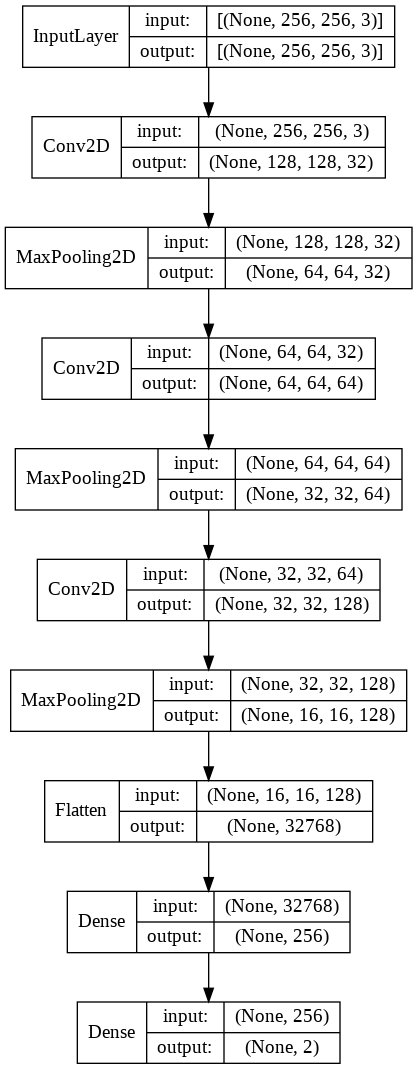

In [672]:
pngOutput = os.path.join(outputPath,'model_plot.png')
plot_model(model, to_file=pngOutput, show_shapes=True, show_layer_names=False)